In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import einsum
import math

### 带有矩阵分解的MLA

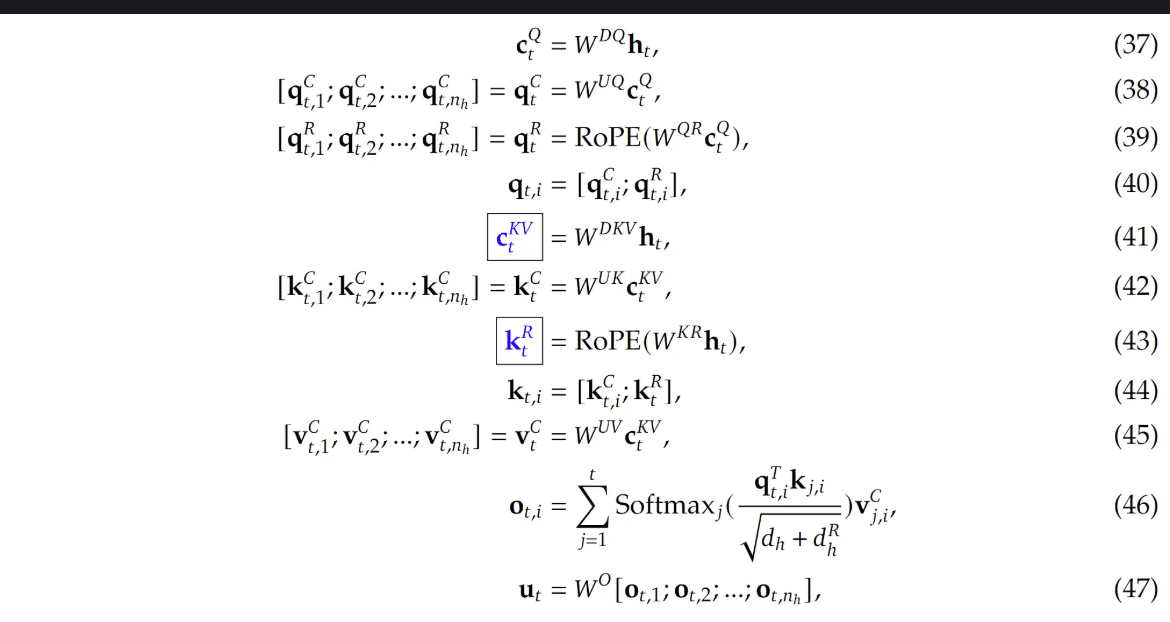

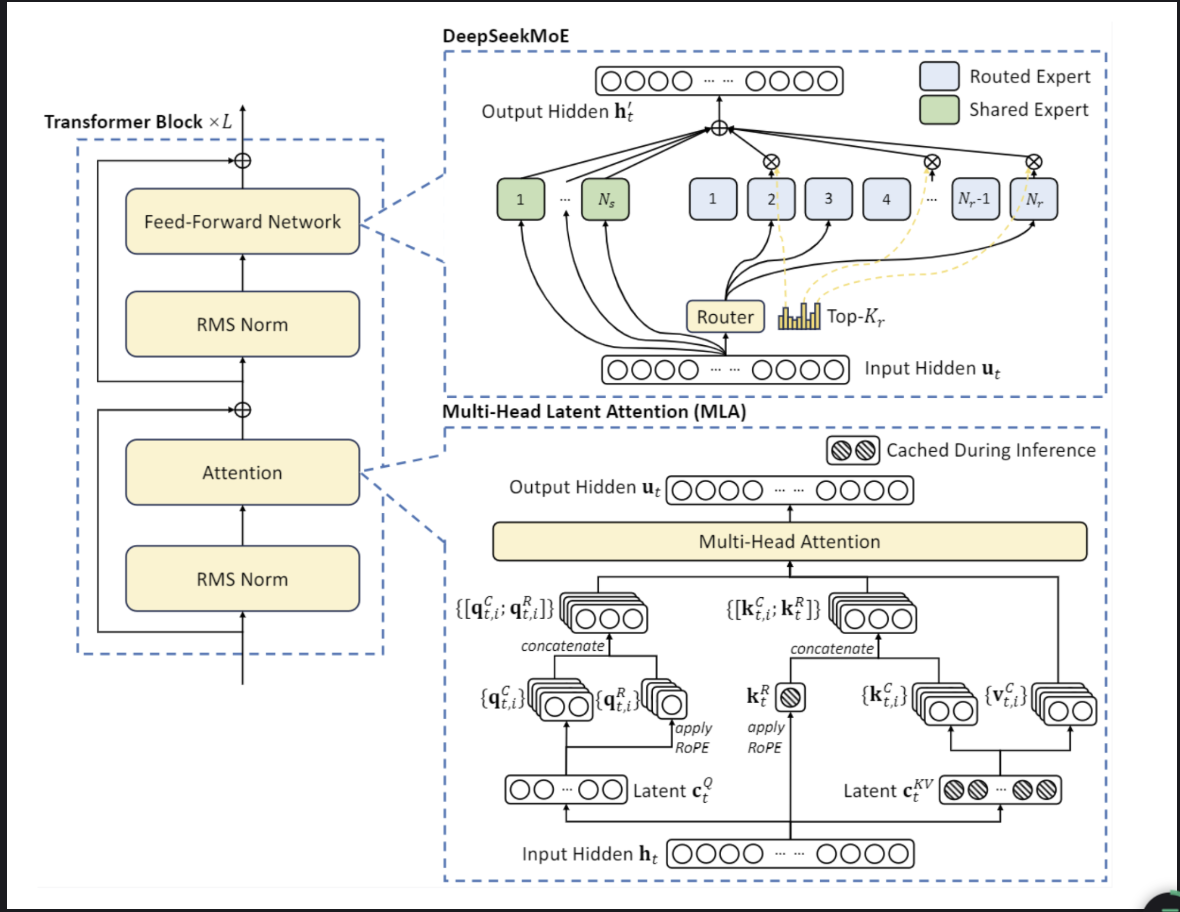

要节约KV cache，应该缓存的是 c_t^KV，而不是 k_t^C, k_t^R, v_t^C

两者入参的区别，很明显 compressed_kv 明显小于完整的 kv，因为 compressed_kv 是所有 head 共享的，缓存的内容从 (batch, seq_len, num_head, nope_dim + rope_dim) 变成了 (batch, seq_len, compressed_dim)。明显减少了缓存内容大小。

但是很明显，这种方式会极大的增加计算量，因为你要从 compressed_dim 升维到正常计算 attention 的 dim，以及需要扩展到 num_head，因为所有 head 是共用 compressed_dim。

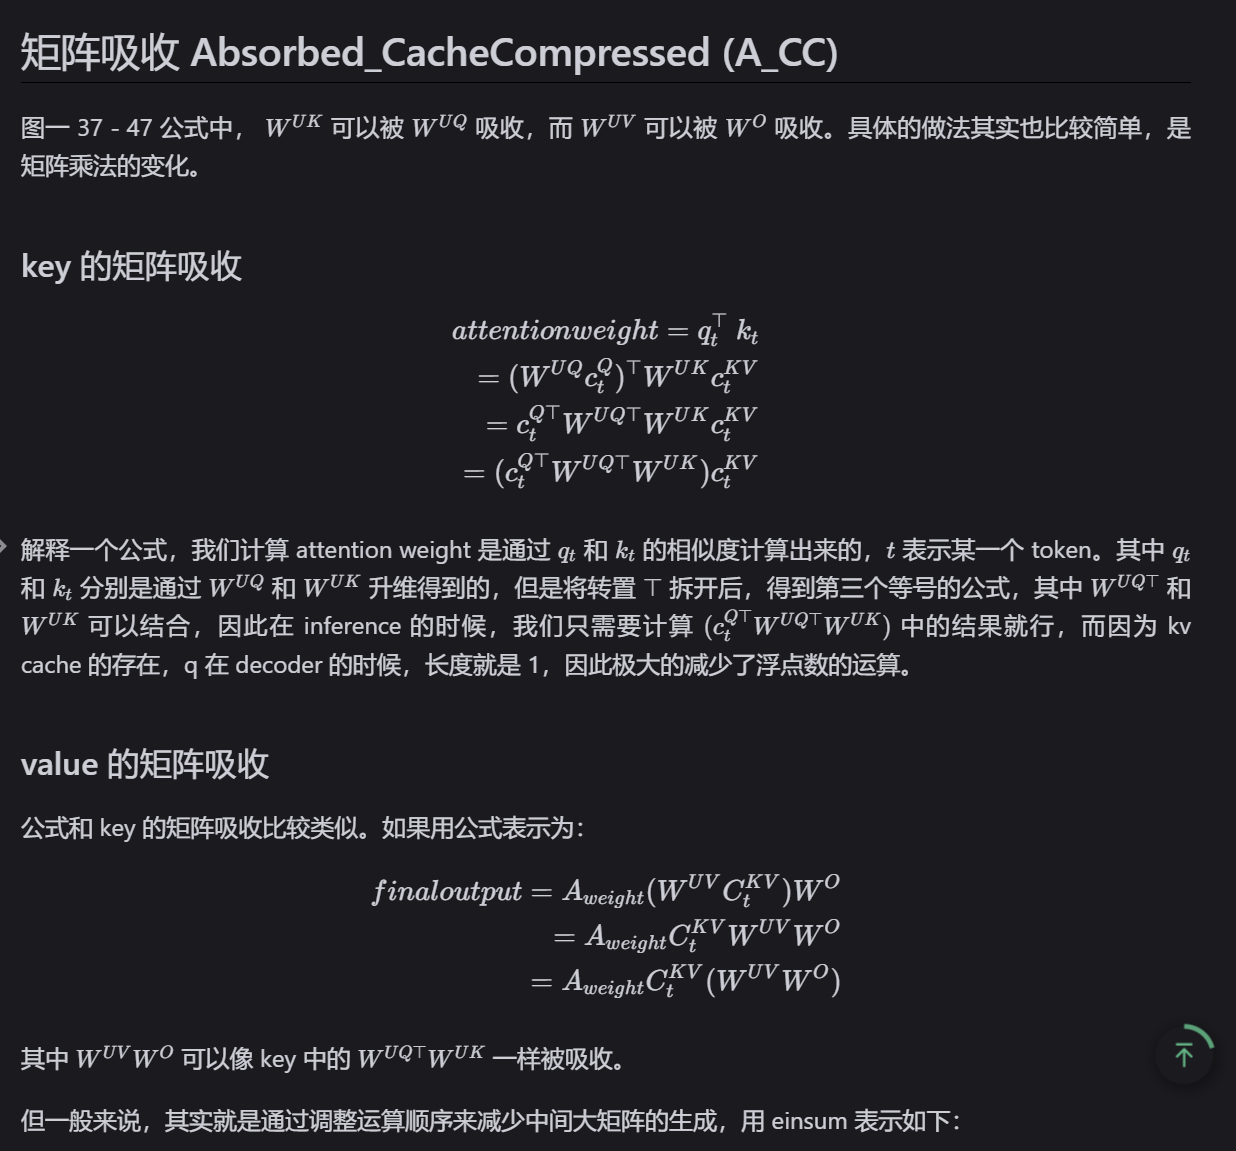

In [22]:
# # h: head_number
# # d: value dim
# # c: compressed_dim
# # l: seq_len
# # q: seq_len
# # D: output_dim/hidden_dim

# final output 的第一行顺序
# v_t = einsum('hdc,blc->blhd', W_UV, c_t_KV) # (1)
# o   = einsum('bqhl,blhd->bqhd', a, v_t)     # (2)
# u   = einsum('hdD,bhqd->bhD', W_o, o)       # (3)

# # 将上述三式合并，得到总的计算过程
# u   = einsum('hdc,blc,bqhl,hdD->bhD', W_UV, c_t_KV, a, W_o)

# final output 的最后一行顺序
# # 利用结合律改变计算顺序
# o_  = einsum('bhql,blc->bhqc', a, c_t_KV) # (4)  
# # # 相对于 1 来说，中间变量更小，从 (b, l, h, d) 变成了(b, h, q, c)
# o   = einsum('bhqc,hdc->bhqd', o_, W_UV)  # (5)
# u   = einsum('hdD,bhqd->bqD', W_o, o)     # (6)

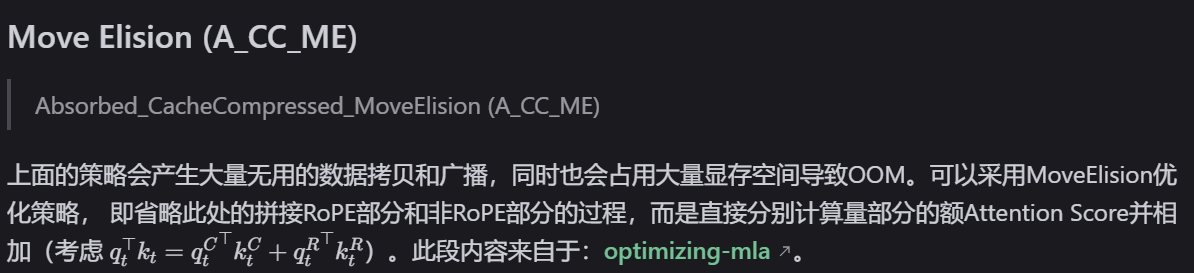

In [23]:
# # Absorbed_CacheCompressed_MoveElision
# def forward(...):
#     ...
#     # qk_head_dim = self.kv_lora_rank + self.qk_rope_head_dim
#     # query_states = k_pe.new_empty(bsz, self.num_heads, q_len, qk_head_dim)
#     # query_states[:, :, :, : self.kv_lora_rank] = torch.einsum('hdc,bhid->bhic', q_absorb, q_nope)
#     # query_states[:, :, :, self.kv_lora_rank :] = q_pe

#     # key_states = k_pe.new_empty(bsz, self.num_heads, kv_seq_len, qk_head_dim)
#     # key_states[:, :, :, : self.kv_lora_rank] = compressed_kv.unsqueeze(1)
#     # key_states[:, :, :, self.kv_lora_rank :] = k_pe

#     # attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) * self.softmax_scale

#     attn_weights = torch.matmul(q_pe, k_pe.transpose(2, 3)) + torch.einsum('bhqc,blc->bhql', q_nope, compressed_kv)
#     attn_weights *= self.softmax_scale
#     ...

### 算法实现

In [24]:
class DeepseekV2RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)
    
class DeepseekV2RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (
            self.base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim)
        )
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        # 较小索引位置对应较低频率
        # 较大的索引位置有较高的频率
        
        # Build here to make `torch.jit.trace` work.
        self._set_cos_sin_cache(
            seq_len=max_position_embeddings,
            device=self.inv_freq.device,
            dtype=torch.get_default_dtype(),
        )
        self.max_seq_len_cached = None

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        t = torch.arange(
            self.max_seq_len_cached, device=device, dtype=self.inv_freq.dtype
        )

        freqs = torch.outer(t, self.inv_freq.to(t.device))
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        if seq_len is None:
            seq_len = x.shape[2]

        if self.max_seq_len_cached is None or seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len=seq_len, device=x.device, dtype=x.dtype)

        return (
            self.cos_cached[:seq_len].to(dtype=x.dtype),
            self.sin_cached[:seq_len].to(dtype=x.dtype),
        )

# Copied from transformers.models.llama.modeling_llama.rotate_half
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

# Copied from transformers.models.llama.modeling_llama.apply_rotary_pos_emb
def apply_rotary_pos_emb(q, k, cos, sin, position_ids, unsqueeze_dim=1):
    cos = cos[position_ids].unsqueeze(unsqueeze_dim)
    sin = sin[position_ids].unsqueeze(unsqueeze_dim)

    b, h, s, d = q.shape
    q = q.view(b, h, s, d // 2, 2).transpose(4, 3).reshape(b, h, s, d)

    b, h, s, d = k.shape
    k = k.view(b, h, s, d // 2, 2).transpose(4, 3).reshape(b, h, s, d)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

# Copied from transformers.models.llama.modeling_llama.apply_rotary_pos_emb
def apply_rotary_pos_emb_v2(q: torch.Tensor, cos, sin, position_ids, unsqueeze_dim=1):
    cos = cos[position_ids].unsqueeze(unsqueeze_dim)
    sin = sin[position_ids].unsqueeze(unsqueeze_dim)

    b, h, s, d = q.shape
    q = q.view(b, h, s, d // 2, 2).transpose(4, 3).reshape(b, h, s, d)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    return q_embed

In [25]:
from dataclasses import dataclass


@dataclass
class DeepseekConfig:
    hidden_size: int
    num_heads: int
    max_position_embeddings: int
    rope_theta: float
    attention_dropout: float

    q_lora_rank: int
    qk_rope_head_dim: int
    kv_lora_rank: int
    v_head_dim: int
    qk_nope_head_dim: int
    attention_bias: bool


class MLAV2(nn.Module):
    def __init__(
        self,
        config,
    ):
        super().__init__()

        self.attention_dropout = config.attention_dropout
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads

        self.max_postion_embeddings = config.max_position_embeddings
        self.rope_theta = config.rope_theta

        # 对应 query 压缩的向量， 在 deepseek v3 中， hidden_size 7168
        # 但是压缩后的 kv d_c= 512，压缩比例 1/14
        # q 的压缩为 1536 压缩比例 1/4.7
        # rope 部分是 64

        self.q_lora_rank = config.q_lora_rank
        # 对应 query 和 key 进行 rope 的维度
        self.qk_rope_head_dim = config.qk_rope_head_dim
        # 对应 value 压缩的向量
        self.kv_lora_rank = config.kv_lora_rank

        # 对应 每一个 Head 的维度大小
        self.v_head_dim = config.v_head_dim

        self.qk_nope_head_dim = config.qk_nope_head_dim
        self.q_head_dim = config.qk_nope_head_dim + config.qk_rope_head_dim

        self.q_down_proj = nn.Linear(
            self.hidden_size,
            self.q_lora_rank,
            bias=config.attention_bias,
        )
        self.q_down_layernorm = DeepseekV2RMSNorm(self.q_lora_rank)

        self.q_up_proj = nn.Linear(
            self.q_lora_rank,
            self.num_heads * self.q_head_dim,
            # 最终还需要做切分（split），一部分是 nope，一部分需要应用 rope
            bias=False,
        )

        # 同理对于 kv 也是一样的
        self.kv_down_proj = nn.Linear(
            self.hidden_size,
            self.kv_lora_rank + self.qk_rope_head_dim,
            bias=config.attention_bias,
        )
        self.kv_down_layernorm = DeepseekV2RMSNorm(self.kv_lora_rank)
        self.kv_up_proj = nn.Linear(
            self.kv_lora_rank,
            self.num_heads
            * (
                self.q_head_dim - self.qk_rope_head_dim + self.v_head_dim
            ),  # 其中 self.q_head_dim - self.qk_rope_head_dim 是 nope 部分
            bias=False,
        )

        # 对应公式 47 行
        self.o_proj = nn.Linear(
            self.num_heads * self.v_head_dim,
            self.hidden_size,
            bias=config.attention_bias,
        )

        # 初始化 rope 的参数
        self.rotary_emb = DeepseekV2RotaryEmbedding(
            self.qk_rope_head_dim,
            self.max_postion_embeddings,
            self.rope_theta,
        )

    def forward(
        self, 
        hidden_states, 
        position_ids = None, 
        attention_mask = None,
        compressed_kv = None
    ):
        # hidden_states shape (batch_size, q_len, hidden_size)
        # 一般generate时，q_len = 1，train的时候和以前一样
        batch_size, q_len, _ = hidden_states.size()

        # 1. 对 query 进行 压缩
        # q shape (batch_size, q_len, q_lora_rank)
        q = self.q_down_proj(hidden_states)
        q = self.q_down_layernorm(q)
        
        # q shape (batch_size, q_len, num_heads, q_head_dim)
        # self.q_head_dim = self.qk_nope_head_dim + self.qk_rope_head_dim
        q = self.q_up_proj(q)
        # q shape (batch_sizem, q_len, num_heads, q_head_dim)
        # q shape (batch_sizem, num_heads, q_len, q_head_dim)
        q = q.view(batch_size, q_len, self.num_heads, self.q_head_dim).transpose(1, 2)
        q_nope, q_rope = torch.split(
            q,
            (self.qk_nope_head_dim, self.qk_rope_head_dim),
            dim = -1
        )

        # 2. kv的部分！这里和上次不一样，kv来自于compressed_kv
        # compressed_kv shape (batch_size, kv_seq_len, kv_lora_rank + qk_rope_head_dim)
        kv_seq_len = compressed_kv.size(1)

        compressed_kv, kv_rope = torch.split(
            compressed_kv,
            (self.kv_lora_rank, self.qk_rope_head_dim),
            dim = -1
        )
        
        # 1 是 num_head 的维度
        # kv_rope shape (batch_size, 1, kv_seq_len, qk_rope_head_dim)
        kv_rope = kv_rope.view(batch_size, kv_seq_len, 1, self.qk_rope_head_dim).transpose(1, 2)
        # 升维时要用不同head的矩阵对compressed_kv进行映射
        # kv_up proj shape (num_heads, qk_nope + v_head_dim, kv_lora_rank)
        kv_up_proj = self.kv_up_proj.weight.view(
            self.num_heads,
            -1,
            self.kv_lora_rank
        )
        
        # q_absorb 是 q_nope 的维度， out_absorb 是 v_head_dim 的维度
        # k的up是和query进行absorb的，所以起名q_absorb
        q_absorb = kv_up_proj[:, :self.qk_nope_head_dim, :]
        # 同理，value是和out进行absorb的，所以起名out_absorb
        out_absorb = kv_up_proj[:, self.qk_nope_head_dim:, :]

        cos, sin = self.rotary_emb(q_rope)
        # 上一次是apply了query和key的rope，这次只要q_rope, compressed_kv已经有k_rope
        q_rope = apply_rotary_pos_emb_v2(q_rope, cos, sin, position_ids)

        # 对应Move Elison公式里面的q_t^C * k_t^C

        # q_nope shape (batch_size, q_len, num_heads, kv_lora_rank)
        q_nope = torch.matmul(
            q_nope, q_absorb
        )
        
        # compressed_kv.unsqueeze(-3) shape (batch_size, 1, kv_seq_len, kv_lora_rank)
        # 再转置得到 shape (batch_size, 1, kv_lora_rank, kv_seq_len)
        # 最后attention_weight shape (batch_size, q_len, num_heads, kv_seq_len)
        attention_weights = (
            torch.matmul(q_rope, kv_rope.mT) # mT代表最后两个维度变换transpose(-1, -2)
            + torch.matmul(q_nope, compressed_kv.unsqueeze(-3).mT)
        ) / math.sqrt(self.q_head_dim)

        attention_weights = nn.functional.softmax(
            attention_weights, dim = -1, dtype = torch.float32
        )
        
        # 通过矩阵变换，我们先算了attention_weight乘上C_t^KV
        # q: q_len, l: kv_seq_len
        attn_output = torch.einsum(
            'bhql,blc->bhqc',
            attention_weights, compressed_kv
        )
        attn_output = torch.matmul(attn_output, out_absorb.mT)
        # 等价于 torch.einsum('bhqc,hdc->bhqd', attn_output, out_absorb)

        attn_output = attn_output.transpose(2, 3).reshape(
            batch_size, q_len, -1
        )
        attn_output = self.o_proj(attn_output)
        return attn_output, attention_weights


In [26]:
# 写一个测试函数
def test_mlav2():
    config = DeepseekConfig(
        hidden_size=7168,
        num_heads=16,
        max_position_embeddings=1024,
        rope_theta=128000,
        attention_dropout=0.1,
        q_lora_rank=1536,
        qk_rope_head_dim=64,
        kv_lora_rank=512,
        v_head_dim=128,
        qk_nope_head_dim=128,
        attention_bias=False,
    )
    # 测试 MLAv2 attention
    # 生成 compressed_kv 的步骤:
    # 1. 先生成原始的 kv hidden states, shape 是 [bsz, kv_seq_len, hidden_size]
    # 2. 用 kv_a_proj_with_mqa 投影到 [bsz, kv_seq_len, kv_lora_rank + qk_rope_head_dim]
    # 3. split 成 compressed_kv 和 k_pe 两部分
    # 4. compressed_kv 过 layernorm
    # 5. k_pe 过 RoPE
    # 6. 最后把 compressed_kv 和 k_pe concat 在一起

    bsz = 2
    q_len = 1
    kv_seq_len = 12
    hidden_size = config.hidden_size

    # 生成测试数据
    q = torch.randn(bsz, q_len, hidden_size).cuda()
    # position_ids = torch.arange(q_len).expand(bsz, -1).cuda()
    position_ids = torch.full((bsz, q_len), 12, dtype=torch.long).cuda()

    # 初始化模型
    model = MLAV2(config).cuda()

    # 先随机初始化一个 compressed_kv
    compressed_kv = torch.randn(
        bsz, kv_seq_len, config.kv_lora_rank + config.qk_rope_head_dim
    ).cuda()
    print(
        "compressed_kv shape:", compressed_kv.shape
    )  # [bsz, kv_seq_len, kv_lora_rank + qk_rope_head_dim]

    # 前向计算
    output, attn_weights = model(q, None, position_ids, compressed_kv)
    print("output shape:", output.shape)  # [bsz, q_len, hidden_size]
    print(
        "attn_weights shape:", attn_weights.shape
    )  # [bsz, num_heads, q_len, kv_seq_len]


test_mlav2()

compressed_kv shape: torch.Size([2, 12, 576])
output shape: torch.Size([2, 1, 7168])
attn_weights shape: torch.Size([2, 16, 1, 12])
